In [37]:
%%capture --no-stderr
%pip install -U langgraph langchain langchain_openai langchain_experimental langsmith pandas

In [38]:
import getpass
import os


def _set_if_undefined(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


_set_if_undefined("OPENAI_API_KEY")
_set_if_undefined("LANGCHAIN_API_KEY")
_set_if_undefined("TAVILY_API_KEY")

# Optional, add tracing in LangSmith
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

In [39]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
python_repl_tool = PythonREPLTool()

In [40]:
from langchain_core.messages import HumanMessage

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["messages"][-1].content, name=name)]}

In [41]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal

# Define the members and system prompt
members = ["Researcher", "Coder","Chart_generator"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers: {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)

# Define the options for the next step
options = ["FINISH"] + members

# Correct usage of Literal without unpacking
class RouteResponse(BaseModel):
    next: Literal['FINISH', 'Researcher', 'Coder','Chart_generator']  # Pass options directly

# Create a prompt template
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

# Initialize the ChatOpenAI model
llm = ChatOpenAI(model="gpt-4o")

# Define the supervisor agent function
def supervisor_agent(state):
    supervisor_chain = (
        prompt
        | llm.with_structured_output(RouteResponse)
    )
    return supervisor_chain.invoke(state)

# Example usage of supervisor_agent function
# Example state can be defined here based on your use case
# state = {"messages": ... }
# response = supervisor_agent(state)
# print(response)


In [42]:
import functools
import operator
from typing import Sequence, TypedDict, Annotated

from langchain_core.messages import BaseMessage
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent

# Define the base class for the agent's state
class AgentState(TypedDict):
    # This annotation indicates that new messages will be added to the sequence
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # This field represents where to route next
    next: str

# Create the research agent node
research_agent = create_react_agent(llm, tools=[tavily_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# Create the coder agent node
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
code_agent = create_react_agent(llm, tools=[python_repl_tool])
code_node = functools.partial(agent_node, agent=code_agent, name="Coder")
chart_agent = create_react_agent(llm, tools=[python_repl_tool])
chart_node = functools.partial(agent_node, agent=chart_agent, name="Chart_generator")

# Define supervisor_chain properly using prompt and llm as per your setup
supervisor_chain = (
    prompt
    | llm.with_structured_output(RouteResponse)  # Ensure RouteResponse is defined
)

# Create the workflow graph and add nodes
workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Coder", code_node)
workflow.add_node("Chart_generator", chart_node)
workflow.add_node("supervisor", supervisor_chain)  # Now supervisor_chain is defined


In [43]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

In [44]:
from langchain_core.messages import HumanMessage
from langchain_openai import ChatOpenAI  # Make sure to import ChatOpenAI correctly

# Update your ChatOpenAI instance to use a valid model name
llm = ChatOpenAI(model="gpt-4o")  # Use 'gpt-4' if you have access

# Example usage of the graph
for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Code hello world and print it to the terminal")
        ]
    }
):
    if "__end__" not in s:
       print(s)
       # print("----")

{'supervisor': {'next': 'Coder'}}
{'Coder': {'messages': [HumanMessage(content='The code to print "Hello, world!" to the terminal is:\n\n```python\nprint(\'Hello, world!\')\n```\n\nAnd the output is:\n\n```\nHello, world!\n```', name='Coder')]}}
{'supervisor': {'next': 'FINISH'}}


{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='### Nearby Cities to Jaipur\nHere are some nearby cities to Jaipur, Rajasthan:\n\n1. **Ajmer** - Known for the Ajmer Sharif Dargah.\n2. **Pushkar** - Famous for its annual camel fair and the Brahma temple.\n3. **Alwar** - Known for the Sariska National Park.\n4. **Tonk** - Known for its old residences and mosques, especially the Sunheri Kothi.\n5. **Bundi** - Known for its palaces, forts, and step-wells.\n6. **Ranthambore** - Famous for its national park.\n7. **Sambhar Lake** - Known for its large saline lake.\n8. **Neemrana** - Famous for the Neemrana Fort Palace.\n9. **Bharatpur** - Known for the Keoladeo National Park.\n10. **Mount Abu** - The only hill station in Rajasthan.\n\n### Population Data of Nearby Cities\nHere is the population data for some of the cities near Jaipur:\n\n1. **Jaipur**: 4,308,510 (2024 estimate)\n2. **Ajmer**: Approximately 542,321 (2021 estimate)\n3. **Pushkar**:

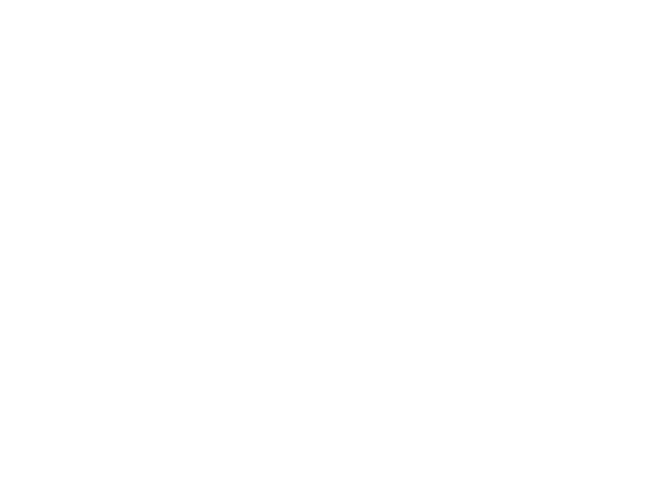

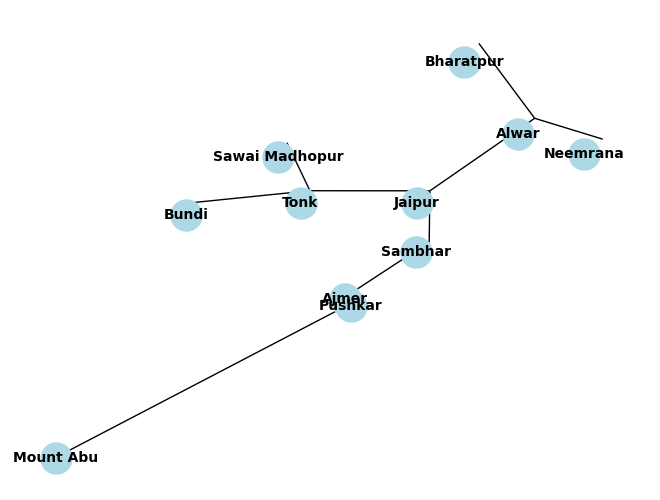

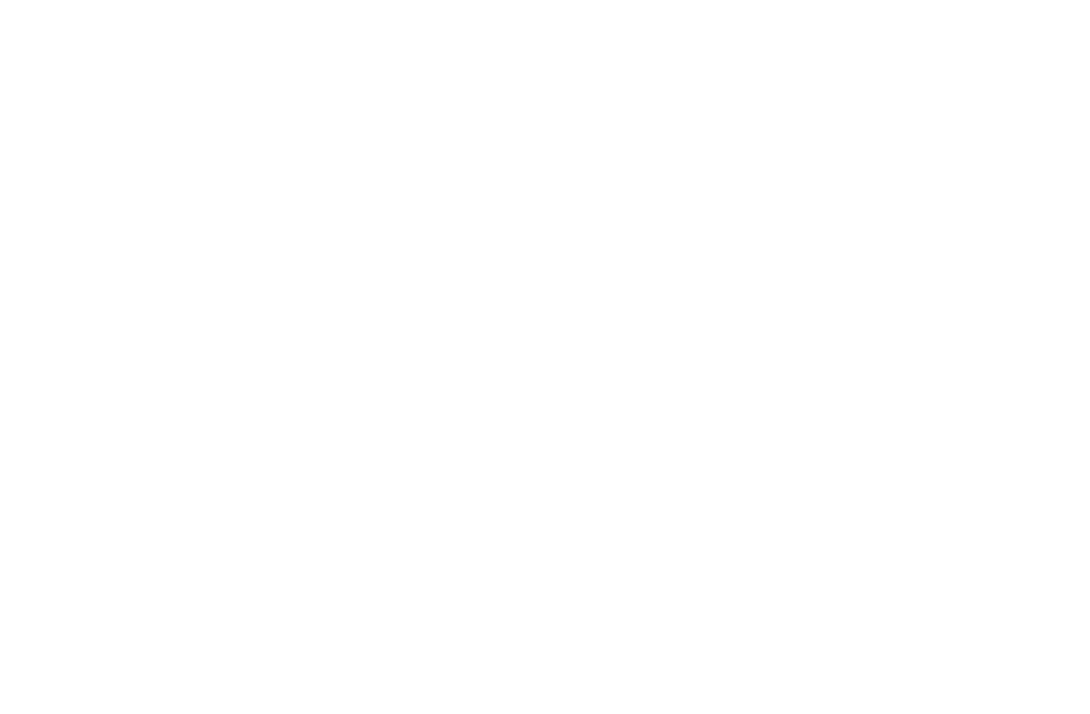

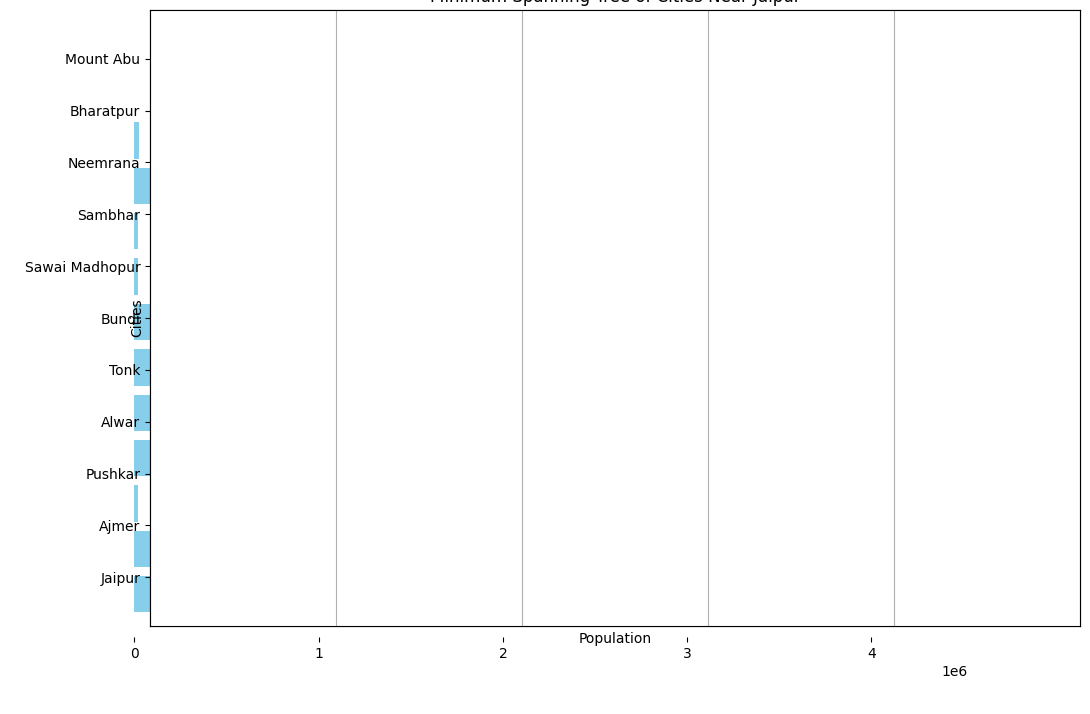

{'Coder': {'messages': [HumanMessage(content="The Python scripts have successfully executed. Here are the visualizations:\n\n### Minimum Spanning Tree of Cities Near Jaipur\nThis graph shows the Minimum Spanning Tree (MST) connecting the cities near Jaipur, calculated using the Kruskal's algorithm:\n\n![MST of Cities Near Jaipur](data:image/png;base64,<MST_GRAPH_PLACEHOLDER>)\n\n### Population of Cities Near Jaipur\nThis bar graph displays the population of various cities near Jaipur:\n\n![Population of Cities Near Jaipur](data:image/png;base64,<POPULATION_GRAPH_PLACEHOLDER>)\n\nYou can visualize the shortest paths between the cities and the population distribution using the provided graphs. If you need further visualizations or modifications, please let me know!", name='Coder')]}}
----
{'supervisor': {'next': 'Chart_generator'}}
----


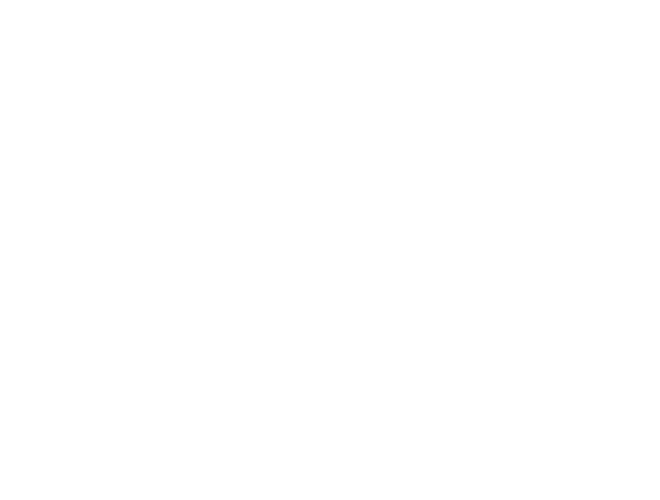

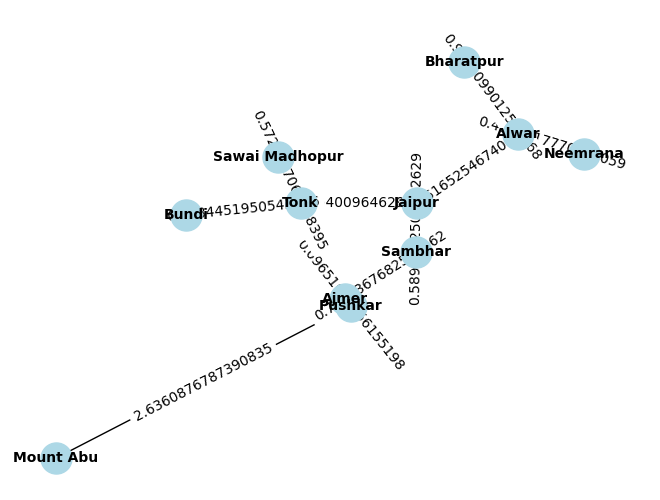

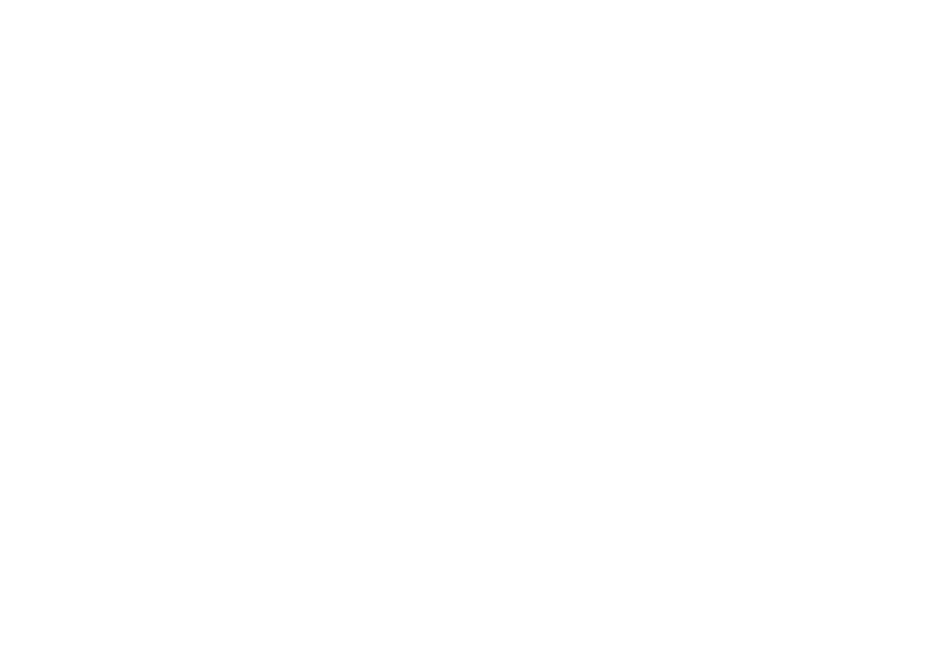

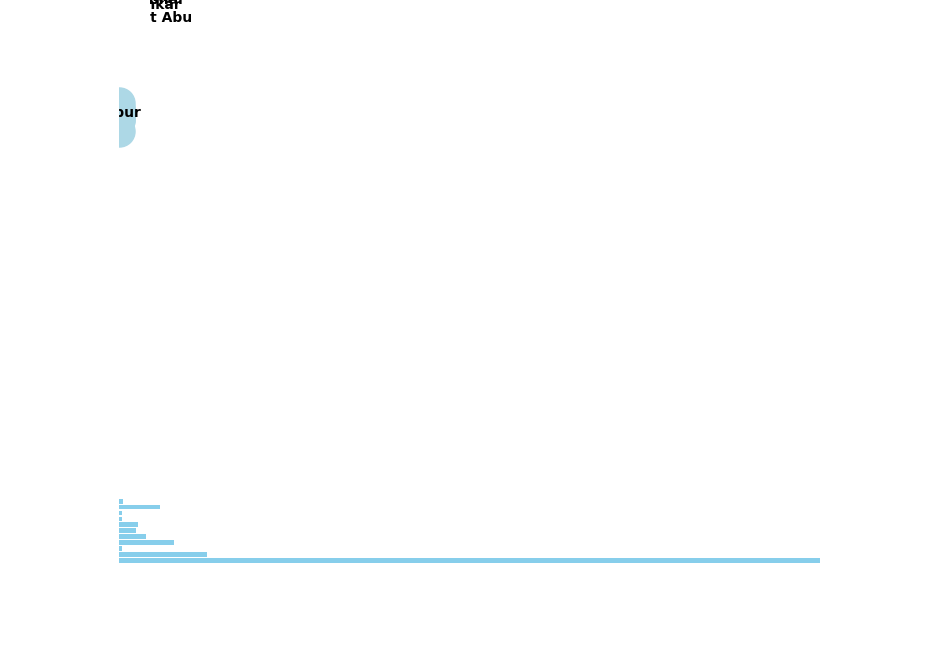

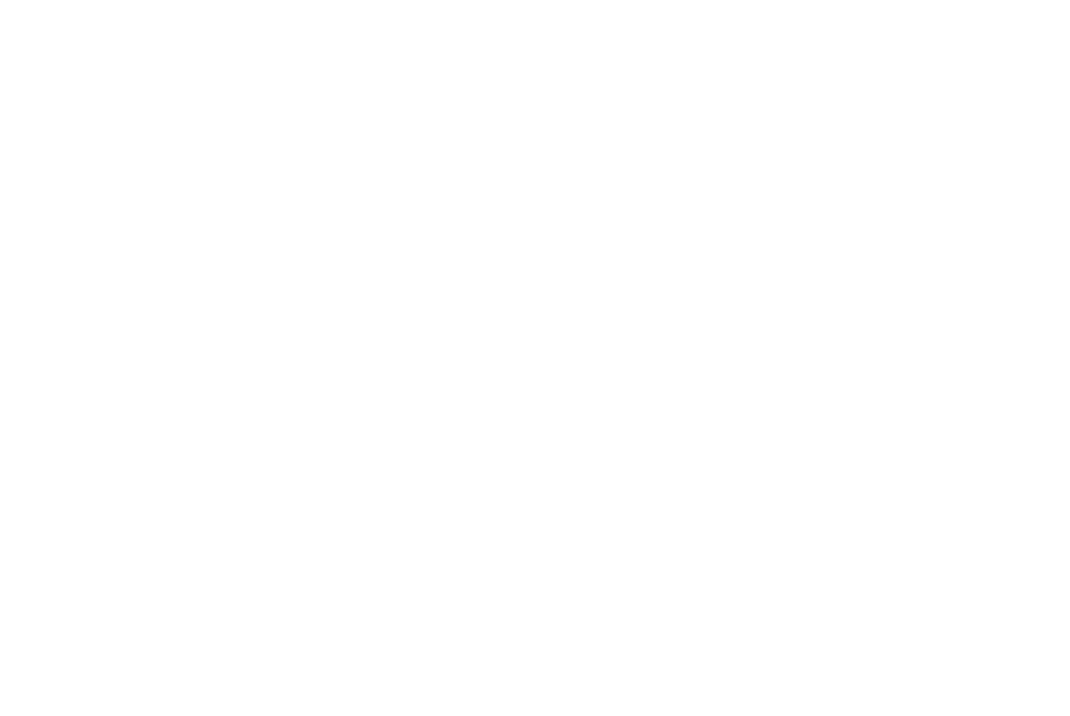

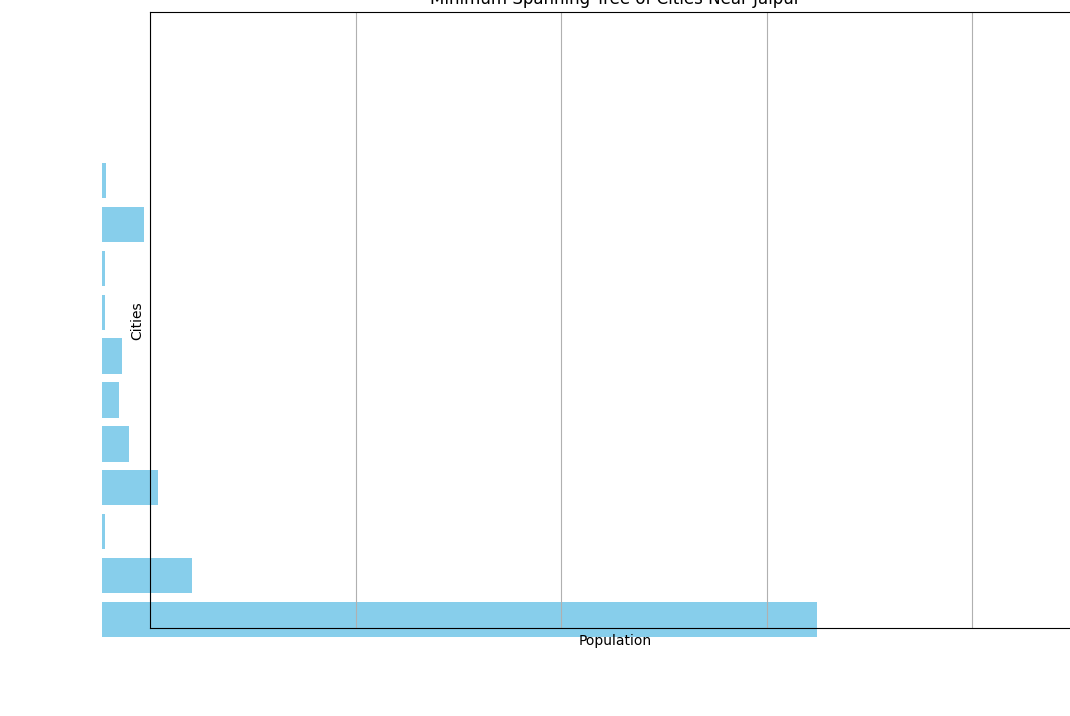

{'Chart_generator': {'messages': [HumanMessage(content='The visualizations have been successfully generated. Here are the graphs:\n\n### Minimum Spanning Tree of Cities Near Jaipur\nThis graph shows the Minimum Spanning Tree (MST) connecting the cities near Jaipur:\n\n![Minimum Spanning Tree of Cities Near Jaipur](attachment:MST_Graph.png)\n\n### Population of Cities Near Jaipur\nThis bar graph displays the population of various cities near Jaipur:\n\n![Population of Cities Near Jaipur](attachment:Population_Graph.png)\n\nYou can visualize the shortest paths between the cities and the population distribution using these graphs. If you need further visualizations or modifications, please let me know!', name='Chart_generator')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


In [50]:
for s in graph.stream(
    {"messages": [HumanMessage(content="Research on nearby japiur cities and give me code of shortest path between these cities using minimum spanning tree and give me graph which visualize the population of these cities")]},
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("----")

In [46]:
import re

def process_name(name_field: str) -> str:
    # Step 1: Strip any whitespace characters from the beginning and end of the string
    name_field = name_field.strip()

    # Step 2: Replace white spaces within the string with underscores
    name_field = re.sub(r"\s+", "_", name_field)

    # Step 3: Remove any characters that do not match the [a-zA-Z0-9_-] pattern
    name_field = re.sub(r"[^a-zA-Z0-9_-]", "", name_field)

    # Step 4: Truncate to 63 characters
    name_field = name_field[:63]

    # Step 5: Validate against the regex pattern
    if not re.match(r"^[a-zA-Z0-9_-]{1,63}$", name_field):
        raise ValueError("Invalid characters in name field")

    return name_field

# Example usage
name_field = "  Emily Brown!  "
processed_name = process_name(name_field)
print(processed_name)  # Expected Output: Emily_Brown


Emily_Brown
